# PMM Implementation: FVEC with Gaussian Potential

## Goal: Train a PMM to find the ground state eigenvalues of the 3D Hamiltonian
$$
  H = \frac{\hat{\mathbf{p}}_\mathbf{r}^2}{2\mu} - V_0 \exp(-\mathbf{r}^2/R^2)
$$
for various volumes. The Hamiltonian can be written
$$
  H = \frac{1}{a^2} T + V^{a^2},
$$
for some lattice spacing $a$. So, we'll train $T$ and $V$ in our PMM.
### Background Theory
For a pair of particles in an attractive Gaussian potential $V(\mathbf{r})=-V_0\exp(-\mathbf{r}^2/R^2)$ ($\mathbf{r} = \mathbf{r}_1 - \mathbf{r}_2$), the Hamiltonian is
$$
  H = \frac{\hat{\mathbf{p}}_{\mathbf{r}_1}}{2m_1} + \frac{\hat{\mathbf{p}}_{\mathbf{r}_2}}{2m_2} + V(\mathbf{r}).
$$
Separating out the CM motion by separating variables with $\mathbf{R} = \frac{1}{m_1+m_2}\left( m_1\mathbf{r}_1 + m_2\mathbf{r}_2\right)$ and $\mathbf{r} = \mathbf{r}_1 - \mathbf{r}_2$, we find
$$
  H_r = \frac{\hat{\mathbf{p}}_{\mathbf{r}}}{2\mu} + V(\mathbf{r})
$$
where $\mu = m_1m_2 / (m_1 + m_2)$ is the reduced mass. The CM motion is just that of a free particle. <br><br>

We discretize over a box with side length $L$. We to discretize with $N^3$ total lattice points ($N$ for each direction), so our lattice spacing is $a = L/N$ and we assume periodic boundary conditions. Thus, the relative coordinate goes from $r \in [-N/2, N/2)$ (if one particle moves over the edge of the boundary, the relative coordinate flips and points in the opposite direction). We choose to index via:
$$
  i = \left(x + \frac{N}{2}\right) + N \left(y + \frac{N}{2}\right) + N^2\left(z + \frac{N}{2}\right).
$$
If we chose to index via $i = x + N y + N^2 z$, we'd have to fold onto $[-N/2,N/2]$ when calculating the distance. Because the kinetic energy operator cares only about neighboring points (i.e., $u_{i+1} - 2 u_i + u_{i-1}$), the kinetic energy operator looks the same regardless of how we index.


### (1) Construct Hamiltonian

In [1]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)

In [2]:
# grab relative positions from index i
def get_relative_coods(i, N):
  if np.any(i < 0) or np.any(i > N**3 - 1):
    print(i)
    raise ValueError(f"i must be between 0 and {N**3 - 1}")
  x = (i % N) - N / 2
  y = ((i % N**2) // N) - N / 2
  z = (i // N**2) - N / 2
  return x, y, z

# calculate relative distance given index i
def get_distance(i, N):
  x, y, z = get_relative_coods(i, N)
  return np.sqrt(x**2 + y**2 + z**2)

In [3]:
def construct_H(N, L, V0=-4.0, R=2.0):
  a = L / N
  N_tot = N**3
  indices = np.arange(N_tot, dtype=np.int32)

  # construct T
  data = -6 * np.ones(N_tot)
  rows = indices
  cols = indices

  x, y, z = get_relative_coods(indices, N)
  neighbors = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
  for dx, dy, dz in neighbors:
    nx = ((x + dx) + N // 2) % N - N // 2                                      # x-neighbor physical cood
    ny = ((y + dy) + N // 2) % N - N // 2                                      # y-neighbor physical cood
    nz = ((z + dz) + N // 2) % N - N // 2                                      # z-neighbor physical cood
    neighbor_indices= (nx + N // 2) + N * (ny + N // 2) + N**2 * (nz + N // 2)  # index of neighbor
    rows = np.concatenate([rows, indices])
    cols = np.concatenate([cols, neighbor_indices])
    data = np.concatenate([data, np.ones(N_tot)])

  T = -1 / a**2 * ss.coo_matrix((data, (rows, cols)), shape=(N_tot, N_tot), dtype=np.complex128).tocsr()

  # construct V
  distances = get_distance(indices, N)
  vs = V0 * np.exp(-(distances * a)**2 / R**2)
  V = ss.diags(vs, format='csr', dtype=np.complex128)

  H = T + V
  return H

Finished calculating eigenvalue for 5.0
Finished calculating eigenvalue for 5.3061224489795915
Finished calculating eigenvalue for 5.612244897959184
Finished calculating eigenvalue for 5.918367346938775
Finished calculating eigenvalue for 6.224489795918368
Finished calculating eigenvalue for 6.530612244897959
Finished calculating eigenvalue for 6.836734693877551
Finished calculating eigenvalue for 7.142857142857142
Finished calculating eigenvalue for 7.448979591836735
Finished calculating eigenvalue for 7.755102040816327
Finished calculating eigenvalue for 8.061224489795919
Finished calculating eigenvalue for 8.36734693877551
Finished calculating eigenvalue for 8.673469387755102
Finished calculating eigenvalue for 8.979591836734695
Finished calculating eigenvalue for 9.285714285714285
Finished calculating eigenvalue for 9.591836734693878
Finished calculating eigenvalue for 9.89795918367347
Finished calculating eigenvalue for 10.204081632653061
Finished calculating eigenvalue for 10.510

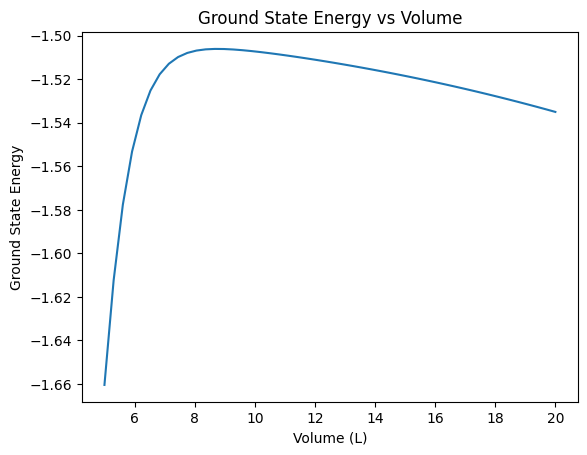

In [4]:
# calculate the ground-state energy for many volumes
N = 32
Ls = np.linspace(5, 20, 50)
eigenvalues = np.zeros(len(Ls), dtype=np.float64)
for i, L in enumerate(Ls):
  H = construct_H(N, L)
  eigvals, _ = ss.linalg.eigsh(H, k=1, which='SA')
  print(f'Finished calculating eigenvalue for {L}')
  eigenvalues[i] = eigvals[0]

fig, ax = plt.subplots()
ax.plot(Ls, eigenvalues, '-')
ax.set_xlabel("Volume (L)")
ax.set_ylabel("Ground State Energy")
ax.set_title("Ground State Energy vs Volume")
plt.show()

### Define the PMM
Construct matrices as $M(L) = A + LB$ as a first guess. The paper discusses that, for any function $f$ (under suitable conditions), we can find an affine eigenvalue PMM that reproduces $f(c)$. We could apply PMMs with a specific reference to the form of the Hamiltonian, but we don't need to, a PMM of the form $M(L) = A + LB$ will likely suffice.

In [5]:
# construct Hamiltonian M after adjusting A, B
def M(A, B, g):
  # force hermiticity
  A = .5 * (A + A.conj().T)
  B = .5 * (B + B.conj().T)

  # if g is given as a scalar, just return A + gB
  # if g is given as a jnp array, return [M(g1), ..., M(gN)]
  if jnp.isscalar(g):
    return A + g * B
  else:
    # reshape g array so that it has dimension (:, 1, 1) for broadcasting with A, B
    return A + g[:, None, None] * B

# get the k-lowest eigenvalues of M (or Ms if M is given as a batch of matrices)
def get_eigenvalues(M, k):
  # M might not be sparse during construction, so use jnp instead of ss
  if M.ndim == 2:
    eigvals = jnp.linalg.eigvalsh(M)[:k]
  elif M.ndim == 3:
    #  jnp eig will vectorize, so pick k lowest eigs for each M_i if given multiple Ms
    eigvals = jnp.linalg.eigvalsh(M)[:, :k]
  else:
    raise ValueError("Input must be a 2D matrix or 3D batch of matrices")
  return eigvals

# loss function
# mean squared error of the predicted eigenvalues to the true eigenvalues
def loss(A, B, gs, Es):
  # if Es are given as a 1D array of scalars, reshape to 2D array:
  # [E1, E2, E3] -> [[E1], [E2], [E3]]
  if Es.ndim == 1:
    Es = Es.reshape(-1, 1)
  # number of lowest-eigenvalues to take is given by shape of Es
  k = Es.shape[1]
  Ms = M(A, B, gs)
  eigs = get_eigenvalues(Ms, k)
  loss = jnp.mean(jnp.abs(eigs - Es)**2)
  # L2 penalty
  penalty = 1e-4 * (jnp.mean(jnp.abs(A)**2) + jnp.mean(jnp.abs(B)**2))
  loss = loss + penalty
  return loss

# define general Adam-update for complex parameters and real-loss functions
def adam_update(parameter, vt, mt, t, grad, eta=1e-2, beta1=0.9, beta2=0.999, eps=1e-8, absmaxgrad=1e3):
  # conjugate the gradient and cap it with absmaxgrad
  gt = jnp.clip(grad.real, -absmaxgrad, absmaxgrad) - 1j * jnp.clip(grad.imag, -absmaxgrad, absmaxgrad)
  # compute the moments (momentum and normalizing) step parameters
  vt = beta1 * vt + (1 - beta1) * gt
  mt = beta2 * mt + (1 - beta2) * jnp.abs(gt)**2

  # bias correction
  vt_hat = vt / (1 - beta1 ** (t + 1))
  mt_hat = mt / (1 - beta2 ** (t + 1))

  # step parameter
  parameter = parameter - eta * vt_hat / (jnp.sqrt(mt_hat) + eps)
  return parameter, vt, mt

def train(A, B, epochs, gs, Es, store_loss=100):
  # construct vt and mt moments
  shape = A.shape
  if shape != B.shape:
    raise ValueError("A and B must have the same shape")
  vt_A = jnp.zeros(shape, dtype=jnp.complex128)
  mt_A = jnp.zeros(shape, dtype=jnp.complex128)

  vt_B = jnp.zeros(shape, dtype=jnp.complex128)
  mt_B = jnp.zeros(shape, dtype=jnp.complex128)

  # create array to store loss at epoch t
  losses = np.zeros(epochs // store_loss)

  # jit the loss function so that it's significantly quicker to call
  jit_loss = jax.jit(loss)

  # define the gradient function
  grad_loss = jax.grad(jit_loss, argnums=(0, 1))

  # update the parameter for every epoch
  for t in range(epochs):
    gt = grad_loss(A, B, gs, Es)
    A, vt_A, mt_A = adam_update(A, vt_A, mt_A, t, gt[0])
    B, vt_B, mt_B = adam_update(B, vt_B, mt_B, t, gt[1])

    if t % store_loss == 0:
      losses_at_t = jit_loss(A, B, gs, Es)
      losses[t // store_loss] = losses_at_t

  # force hermiticity one last time
  A = .5 * (A + A.conj().T)
  B = .5 * (B + B.conj().T)

  return A, B, losses

In [6]:
# set up training data for PMM
k_num = 1
Ls_train = np.linspace(5, 20, 20)
eigenvalues_train = np.zeros((len(Ls_train), k_num), dtype=np.float64)
for i, L in enumerate(Ls_train):
  H = construct_H(N, L)
  eigvals, _ = ss.linalg.eigsh(H, k=k_num, which='SA')
  eigvals = np.sort(eigvals)
  print(f'Finished calculating eigenvalue for {L}:', eigvals)
  eigenvalues_train[i] = eigvals

Finished calculating eigenvalue for 5.0: [-1.66048104]
Finished calculating eigenvalue for 5.7894736842105265: [-1.56243126]
Finished calculating eigenvalue for 6.578947368421053: [-1.52379518]
Finished calculating eigenvalue for 7.368421052631579: [-1.51046779]
Finished calculating eigenvalue for 8.157894736842106: [-1.5065888]
Finished calculating eigenvalue for 8.947368421052632: [-1.50609025]
Finished calculating eigenvalue for 9.736842105263158: [-1.50683123]
Finished calculating eigenvalue for 10.526315789473685: [-1.5080761]
Finished calculating eigenvalue for 11.31578947368421: [-1.50957322]
Finished calculating eigenvalue for 12.105263157894736: [-1.51123653]
Finished calculating eigenvalue for 12.894736842105264: [-1.51303689]
Finished calculating eigenvalue for 13.68421052631579: [-1.51496499]
Finished calculating eigenvalue for 14.473684210526315: [-1.51701855]
Finished calculating eigenvalue for 15.263157894736842: [-1.5191978]
Finished calculating eigenvalue for 16.052631

Loss at epoch 14900: 0.0009539688471765567


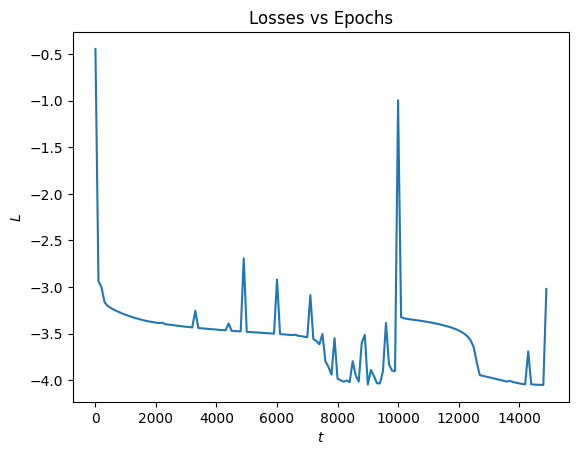

In [7]:
epochs = 15000
n = 3
store_loss = 100

mag = .5e-1
seed = 1 # 1 (mag = .5e-1, everything else default)
key = jax.random.key(seed)
key1, key2 = jax.random.split(key, 2)
A = jax.random.normal(key1, shape=(n, n), dtype=jnp.complex128)
B = jax.random.normal(key2, shape=(n, n), dtype=jnp.complex128)

A = .5 * (A + A.conj().T)
B = .5 * (B + B.conj().T)

A *= mag
B *= mag

# train the PMM using a sample set of L and eigenvalues defined above
Ls_train = jnp.array(Ls_train)
eigenvalues_train = jnp.array(eigenvalues_train)
A, B, losses = train(A, B, epochs, Ls_train, eigenvalues_train, store_loss=store_loss)
print(f"Loss at epoch {(len(losses) - 1)* store_loss}: {losses[-1]}")

fig, ax = plt.subplots()
ax.plot(store_loss * np.arange(len(losses)), np.log10(losses), '-')
ax.set_ylabel(r'$L$')
ax.set_xlabel(r'$t$')
ax.set_title(r'Losses vs Epochs')
plt.show()

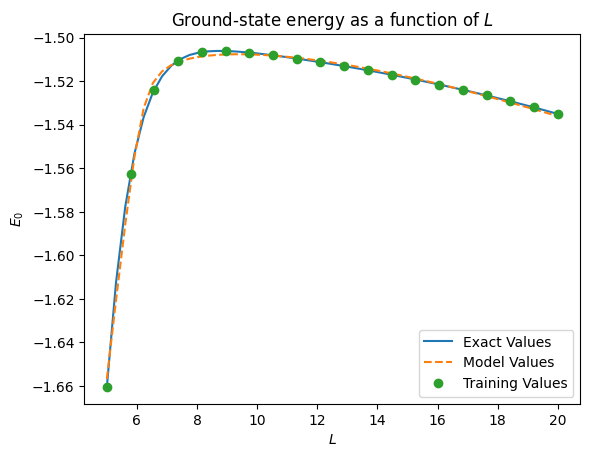

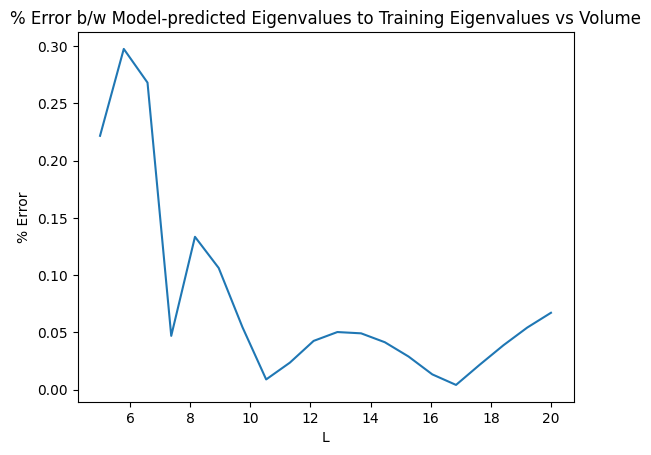

In [8]:
Ls = jnp.array(Ls)
eigenvalues_model = get_eigenvalues(M(A, B, Ls), k_num)

fig, ax = plt.subplots()
ax.plot(Ls, eigenvalues, '-', label='Exact Values')
ax.plot(Ls, eigenvalues_model[:,0], '--', label='Model Values')
ax.plot(Ls_train, eigenvalues_train[:,0], 'o', label='Training Values')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$E_0$')
ax.set_title(r'Ground-state energy as a function of $L$')
ax.legend()
plt.show()

percent_error = 100 * np.abs(get_eigenvalues(M(A, B, Ls_train), k_num) - eigenvalues_train) / np.abs(eigenvalues_train)
fig, ax = plt.subplots()
ax.plot(Ls_train, percent_error, '-')
ax.set_xlabel('L')
ax.set_ylabel('% Error')
ax.set_title('% Error b/w Model-predicted Eigenvalues to Training Eigenvalues vs Volume')
plt.show()